In [1]:
import pandas as pd
from efficientnet_pytorch import EfficientNet
import numpy as np
import pandas as pd
import torch
from torchvision import transforms
torch.cuda.empty_cache()

import glob

from sklearn.metrics.pairwise import cosine_similarity

import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
torch.cuda.empty_cache()
import boto3
import cv2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
os.environ['AWS_ACCESS_KEY_ID'] = 'AWS_ACCESS_KEY_ID'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'AWS_SECRET_ACCESS_KEY'

s3 = boto3.resource('s3')

def read_image_from_s3(key):
    bucket = s3.Bucket('You s3 path')
    img = bucket.Object(key).get().get('Body').read()
    img = cv2.imdecode(np.asarray(bytearray(img)), cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [3]:
def read_csv_from_s3(stage):

    if stage == 'public':
        df = pd.read_csv('You public csv path')
    elif stage == 'private':
        df = pd.read_csv('You private csv path')
    elif stage == 'public_private':
        df = pd.read_csv('You public_private csv path')
    elif stage == 'index':
        df = pd.read_csv('You index csv path')
        

    else:
        raise ValueError(f'not supported stage{stage}')
    return df

In [4]:
class SiameseGLDV2(Dataset):

    def __init__(self, stage: str, inferance=True):

        self.df = read_csv_from_s3(stage)
        self.df.drop(self.df.filter(regex="Unname"), axis=1, inplace=True)
        self.label_list = self.df.landmark_id.tolist()
        self.namelist = [i.split('\\')[-1] for i in self.df.anchor.tolist()]
        print(f'shape of df is {len(self.df)}, stage is {stage}')
        self.s3 = boto3.resource('s3')
        if stage == 'index':
            self.s3path = 'data/train/train_compress'
        else:
            self.s3path = 'data/test'
        self.my_transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])


    def __getitem__(self, index):
        label = self.df.iloc[index]['landmark_id']
        anchor = self.df.iloc[index]['anchor'].split('\\')
        anchor_class = anchor[1]
        anchor_filen = anchor[2]
        anchor_image = self.s3path + '/' + anchor_class + '/' + anchor_filen
        try:
            anchor_im = read_image_from_s3(anchor_image)
        except:
            anchor_im = []
            print(f'Error by {anchor_image}')
        transformed_anchor_im = self.my_transformer(anchor_im)
        return label, transformed_anchor_im , anchor_im

In [5]:
def map_at_k(y_true, y_denominator, y_pred):
    assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray)
    assert y_true.ndim == 2 and y_pred.ndim == 2

    k = y_pred.shape[1]
    is_correct_list = []

    for i in range(y_true.shape[1]):
        is_correct = y_true[:, i][:, np.newaxis] == y_pred
        is_correct_list.append(is_correct)
    print(is_correct_list)
    is_correct_mat = np.logical_or.reduce(np.array(is_correct_list))

    cumsum_mat = np.apply_along_axis(np.cumsum, axis=1, arr=is_correct_mat)
    arange_mat = np.expand_dims(np.arange(1, k + 1), axis=0)
    ap_100_list = np.sum((cumsum_mat / arange_mat) * is_correct_mat, axis=1) / y_denominator
    ap_100_list[ap_100_list>1]=1

    return np.mean(ap_100_list), ap_100_list

def list_to_array (x):
    dff = pd.concat([pd.DataFrame({'{}'.format(index):labels}) for index,labels in enumerate(string_to_list(x))],axis=1)
    return dff.fillna(0).values.T.astype(int)

def string_to_list(x):
    res = []
    for a in x:
        tmp = a.split(' ')
        tmp2= [int(i) for i in tmp]
        res.append(tmp2)
    return res

In [6]:
BATCH_SIZE = 500
class NN:
    def __init__(self, batch_size=BATCH_SIZE, dim=512):
        self.array = np.empty((0, dim))
        self.id = []
        self.score = np.empty((0, batch_size))

    def add_item(self, item):
        if item.ndim == 1:
            item = item[np.newaxis, :]
        self.array = item

    def search(self, search_item, top_k=100):
        self.res = cosine_similarity(self.array, search_item)
        self.score = np.concatenate((self.score, self.res), axis=0)
        self.rank = self.res[:, 0].argsort()[::-1][:top_k]

    def update(self):
        self.array = np.array([self.array[i] for i in self.rank])
        self.id = [self.id[i] for i in self.rank]

    def get_top_k(self, top_k=100):
        self.note = -np.sort(-self.score,axis = 0)[:top_k, :]
        return np.argsort(-self.score, axis=0)[:top_k, :]

def index_to_label(index_array, label_list):
    res = []
    for i in range(len(index_array)):
        res.append(label_list[index_array[i].astype(int)])
    return np.array(res)

def comt_denominater(y_true, index_label_list):
    res = []
    for i in y_true:
        count = 0
        for j in i:
            count += index_label_list.count(j)
        res.append(count)
    res = np.array(res)
    res[res > 50] = 50
    return res

In [7]:
index_dataset = SiameseGLDV2('index')
test_dataset = SiameseGLDV2('public')

shape of df is 100000, stage is index
shape of df is 350, stage is public


In [8]:
npy_list_index = sorted(glob.glob('out/index/*.npy'))
npy_list_test = sorted(glob.glob('out/test/*.npy'))
images = []
score_list = []
ranked_list = []
aps = []
for ind,npy_test_path in tqdm(enumerate(npy_list_test)):
    npy_test = np.load(npy_test_path)
    indexer = NN(dim=1000, batch_size=npy_test.shape[0])
    for i,npy_index_path in tqdm(enumerate(npy_list_index)):
        npy_index = np.load(npy_index_path)
        indexer.add_item(npy_index)
        indexes = indexer.search(npy_test)
    top_k_array = indexer.get_top_k()
    ranked_list.append(top_k_array)
    y_true = list_to_array(test_dataset.label_list[ind*BATCH_SIZE:min((ind+1)*BATCH_SIZE, len(test_dataset.label_list))])
    map_100,ap_list = map_at_k(y_true= y_true,
             y_denominator= comt_denominater(y_true, index_dataset.label_list),
             y_pred= index_to_label(top_k_array.T,np.array(index_dataset.label_list)))
    aps.extend(ap_list)
    score_list.append(indexer.note)
ranked_list = np.hstack(ranked_list)
score_list = np.hstack(score_list)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
9it [00:00, 83.91it/s]
18it [00:00, 58.84it/s]
25it [00:00, 47.24it/s]
31it [00:00, 38.66it/s]
36it [00:00, 33.04it/s]
40it [00:01, 29.33it/s]
44it [00:01, 26.29it/s]
47it [00:01, 24.26it/s]
50it [00:01, 22.46it/s]
53it [00:01, 20.81it/s]
56it [00:01, 19.42it/s]
58it [00:02, 18.54it/s]
60it [00:02, 17.75it/s]
62it [00:02, 16.86it/s]
64it [00:02, 16.20it/s]
66it [00:02, 15.64it/s]
68it [00:02, 15.00it/s]
70it [00:02, 14.54it/s]
72it [00:03, 14.14it/s]
74it [00:03, 13.65it/s]
76it [00:03, 13.29it/s]
78it [00:03, 12.99it/s]
80it [00:03, 12.62it/s]
82it [00:03, 12.35it/s]
84it [00:04, 12.10it/s]
86it [00:04, 11.78it/s]
88it [00:04, 11.56it/s]
90it [00:04, 11.34it/s]
92it [00:04, 11.05it/s]
94it [00:05, 10.86it/s]
96it [00:05, 10.67it/s]
98it [00:05, 10.40it/s]
100it [00:05, 10.24it/s]
102it [00:05, 10.08it/s]
104it [00:06,  9.86it/s]
105it [00:06,  9.81it/s]
106it [00:06,  9.64it/s]
107it [00:06,  9.51it/s]
108it [00:06,  9.46it/s]
109it [00:06,  9.29i

[array([[ True,  True,  True, ..., False, False,  True],
       [ True,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False,  True, False, ..., False, False, False],
       [ True,  True,  True, ..., False,  True, False],
       [ True,  True,  True, ..., False, False, False]]), array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       

In [9]:
print(index_to_label(top_k_array.T,np.array(index_dataset.label_list)))

[[100951 100951 100951 ... 195366 181954 100951]
 [102307 102307  69107 ... 155152 109439 111855]
 [183859  76441 102307 ... 162116  71586 109566]
 ...
 [118433  94320 189427 ... 135165  66478 128396]
 [ 94881  94881  94881 ... 163321  94881   1607]
 [ 95293  95293  95293 ...  28503  96828  58979]]


In [10]:
print('The map@100 is : {}'.format(np.mean(aps)))
print('The max ap@100 is : {}'.format(np.max(aps)))
print('The min ap@100 is : {}'.format(np.min(aps)))

The map@100 is : 0.3267507395142675
The max ap@100 is : 0.9721175366399537
The min ap@100 is : 0.0


In [11]:
!pip install opencv-contrib-python
import cv2

In [12]:
def getMatchNum(matches,ratio):
    '''返回特征点匹配数量和匹配掩码'''
    matchesMask=[[0,0] for i in range(len(matches))]
    matchNum=0
    for i,(m,n) in enumerate(matches):
        if m.distance<ratio*n.distance: #将距离比率小于ratio的匹配点删选出来
            matchesMask[i]=[1,0]
            matchNum+=1
    return (matchNum,matchesMask)

def sift_reranking(index_dataset, test_dataset, rank_list,global_score, v = 0.8):
    local_score = []
    for idx,(_,_,im) in tqdm(enumerate(test_dataset)):
#         if idx == 50:
#             break
        #创建SIFT特征提取器
        sift = cv2.xfeatures2d.SIFT_create()
        #创建FLANN匹配对象
        FLANN_INDEX_KDTREE=0
        indexParams=dict(algorithm=FLANN_INDEX_KDTREE,trees=5)
        searchParams=dict(checks=50)
        
        comparisonImageList=[] #记录比较结果
        flann=cv2.FlannBasedMatcher(indexParams,searchParams)
        
        kp1, des1 = sift.detectAndCompute(im, None) #提取样本图片的特征

        for i in rank_list[:,idx]:
            _,_,queryImage=index_dataset[i]
            kp2, des2 = sift.detectAndCompute(queryImage, None) #提取比对图片的特征
            try:
                matches=flann.knnMatch(des1,des2,k=2) #匹配特征点，为了删选匹配点，指定k为2，这样对样本图的每个特征点，返回两个匹配
                (matchNum,matchesMask)=getMatchNum(matches,0.7) #通过比率条件，计算出匹配程度 0.6 0.7 0.65 0.67
                matchRatio=matchNum/len(matches)
            except:
                matchRatio = 0
            comparisonImageList.append(matchRatio) #记录下结果

        local_score.append(comparisonImageList)
    
    local_score = np.array(local_score).T
    final_score = v*global_score + (1-v) * local_score
    rank = np.argsort(-final_score, axis=0)
    final_rank = [rank_list[:, i][rank[:,i]] for i in range(final_score.shape[1])]
    return final_score, np.array(final_rank)

In [13]:
final_score, final_rank = sift_reranking(index_dataset, test_dataset, np.array(ranked_list),score_list, v = 0.8)

y_true = list_to_array(test_dataset.label_list) # [:50]
map_100,ap_list = map_at_k(y_true= y_true,
        y_denominator= comt_denominater(y_true, index_dataset.label_list),
        y_pred= index_to_label(final_rank,np.array(index_dataset.label_list)))

0it [00:00, ?it/s][ WARN:0] global /tmp/pip-req-build-th1mncc2/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (13) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736
350it [34:45,  5.96s/it]


[array([[ True,  True,  True, ..., False, False,  True],
       [ True,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]]), array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       

In [14]:
print('The map@100 is : {}'.format(np.mean(ap_list)))
print('The max ap@100 is : {}'.format(np.max(ap_list)))
print('The min ap@100 is : {}'.format(np.min(ap_list)))
print('The max cos similarity is : {}'.format(max(ap_list)))


The map@100 is : 0.32710849808313613
The max ap@100 is : 0.9715912208504801
The min ap@100 is : 0.0
The max cos similarity is : 0.9715912208504801


In [15]:
def display_query_and_top_k_match(query_dataset, index_dataset, ranked_list, index, k=24, width=5):
    row = int((k+1)//width)
    k = row * width -1
    images = []
    top_k_indices = ranked_list[:,index]
    top_k_index = top_k_indices[:k]
    label, _, query_img_path = query_dataset[index]
    fig = plt.figure(figsize=(10, row*3.3))
    a = plt.subplot(row, width, 1)
    plt.subplots_adjust(left=0.1, bottom = 0.1, right = 0.95, wspace = 0.1, hspace=0, top = 0.7)
    plt.imshow(query_img_path)
    a.set_title(f'Query image: {label}')
    a.set_xticks([])
    a.set_yticks([])
    
    for i in range(1,k+1):
        label, _, index_img_path = index_dataset[top_k_index[i-1]]
        a = plt.subplot(row, width, i+1)
        plt.imshow(index_img_path)
        a.set_title(f'top{i}:{label}')
        a.set_xticks([])
        a.set_yticks([])
        
    plt.show()

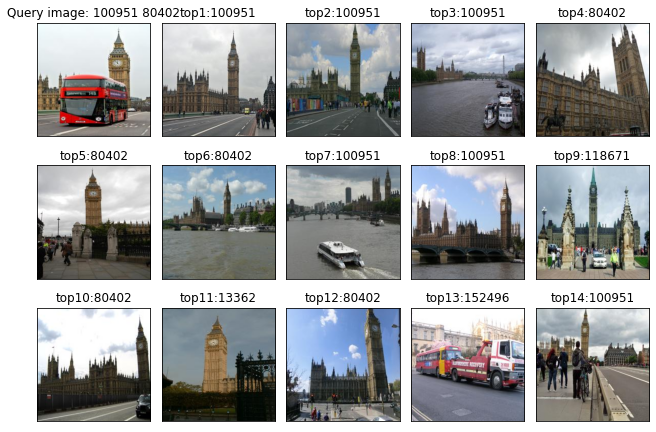

In [16]:
display_query_and_top_k_match(test_dataset, index_dataset, ranked_list, 0, k=14)

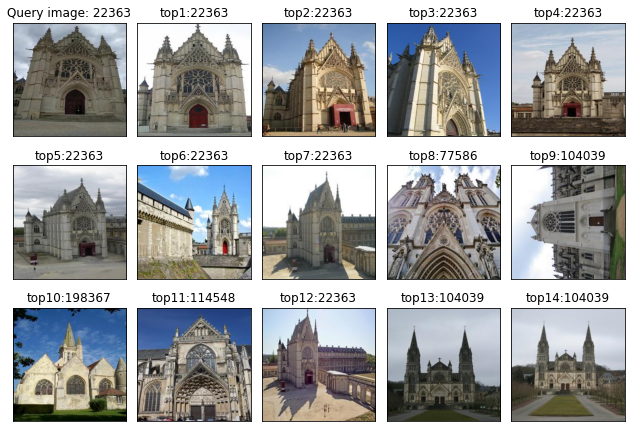

In [17]:
display_query_and_top_k_match(test_dataset, index_dataset, ranked_list, 230, k=14)